In [1]:
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Playing with type-B QPO data
## Loading data

In [2]:
lc_fits = Table.read('./BQPO_psd_rb.fits')
meta = lc_fits.meta
print(lc_fits.info())
lc_fits

<Table length=94>
   name    dtype     unit   
--------- ------- ----------
FREQUENCY float32         Hz
    POWER float32 frac rms^2
    ERROR float32 frac rms^2
None


FREQUENCY,POWER,ERROR
Hz,frac rms^2,frac rms^2
float32,float32,float32
0.0,-0.0007862593,0.0
0.014960597,0.018399091,0.0013465476
0.029921195,0.015440796,0.001138916
0.044881795,0.010862097,0.00081755436
0.05984239,0.0058397288,0.0004650532
0.07480299,0.005619941,0.00044962708
0.08976359,0.0044035064,0.00036425013
0.11220448,0.0038934425,0.0002323083


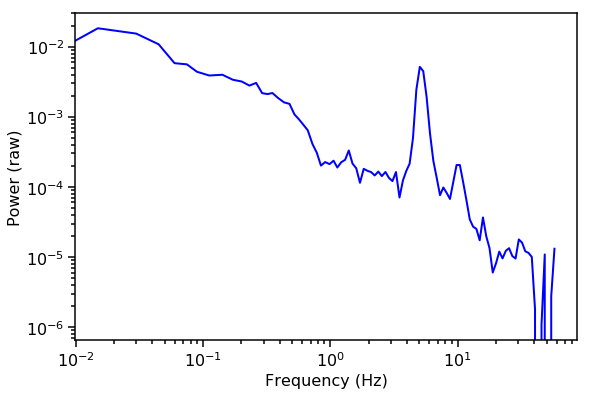

In [3]:
avg_ps = AveragedPowerspectrum()
avg_ps.norm = "leahy"
avg_ps.freq = lc_fits['FREQUENCY']
avg_ps.power = lc_fits['POWER']
avg_ps.power_err = lc_fits['ERROR']
avg_ps.df = avg_ps.freq[1] - avg_ps.freq[0]

range_start = 0
range_stop = int(len(avg_ps.freq))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.loglog(avg_ps.freq[range_start:range_stop], avg_ps.power[range_start:range_stop], lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

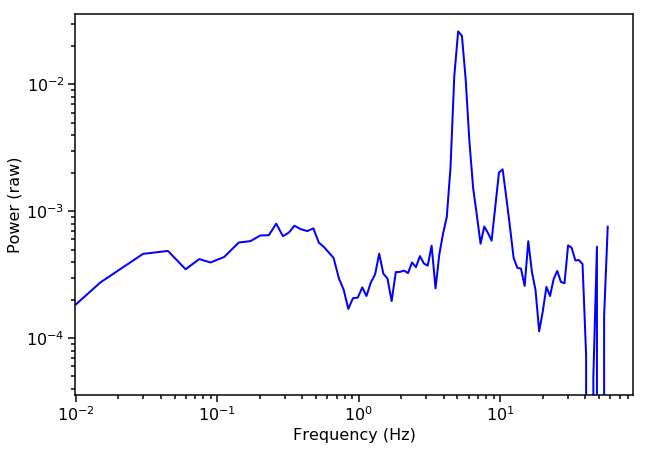

In [4]:
# Plotting power*freq vs. freq
range_start = 0
range_stop = int(len(avg_ps.freq))

power_freq = avg_ps.power * avg_ps.freq

fig, ax1 = plt.subplots(1,1,figsize=(10,7))
ax1.loglog(avg_ps.freq[range_start:range_stop], power_freq[range_start:range_stop], lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [5]:
max_index = avg_ps.power.argmax()
max_freq = avg_ps.freq[max_index]
max_power = avg_ps.power[max_index]
max_power-0.005

0.013399091437458991

## Fitting model

In [6]:
def find_nearest_arg(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

52
Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=5.05668259, fwhm=1.)>

    [1]: <Lorentz1D(amplitude=1., x_0=0., fwhm=1.)>

    [2]: <Lorentz1D(amplitude=1., x_0=0., fwhm=1.)>

    [3]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>
Parameters:
    amplitude_0       x_0_0       fwhm_0 amplitude_1 ... amplitude_3 x_0_3 alpha_3
    ----------- ----------------- ------ ----------- ... ----------- ----- -------
            1.0 5.056682586669922    1.0         1.0 ...         1.0   1.0     1.0


/anaconda3/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: divide by zero encountered in power
  return amplitude * xx ** (-alpha)


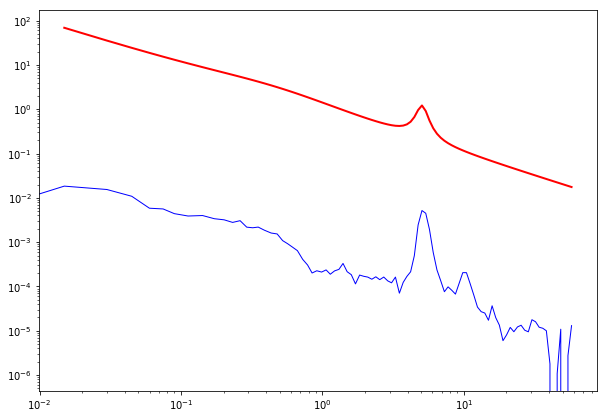

In [7]:
max_freq_index = find_nearest_arg(avg_ps.freq, 5)
x_0 = avg_ps.freq[max_freq_index]
print(max_freq_index)
model = models.Lorentz1D(x_0=x_0) + \
        models.Lorentz1D() + models.Lorentz1D() + \
        models.PowerLaw1D()
print(model)

fitter = fitting.LevMarLSQFitter()
fit_fn = fitter(model, avg_ps.freq, avg_ps.power)
fit = fit_fn(avg_ps.freq)
# plotting
plt.figure(figsize=(10,7))
plt.loglog(avg_ps.freq, avg_ps.power, lw=1, color='blue')
plt.loglog(avg_ps.freq, fit, lw=2, color="red")

# Playing with type-C QPO
## Loading data

In [8]:
lc_fits_c = Table.read('./CQPO_psd_rb.fits')
meta = lc_fits_c.meta
print(lc_fits_c.info())
lc_fits_c

<Table length=163>
   name    dtype  unit
--------- ------- ----
FREQUENCY float64   Hz
    POWER float64     
    ERROR float64     
None


FREQUENCY,POWER,ERROR
Hz,,
float64,float64,float64
0.0,0.0,0.0
0.016168135017514067,12072167933.126554,1106653820.0169282
0.03233627003502813,16194263426.561087,1484525694.360748
0.0485044050525422,15018295662.717033,1376724906.193801
0.06467254007005627,19255632533.47843,1765160940.2767208
0.08084067508757034,16798597991.8106,1539924953.1273906
0.0970088101050844,13643068290.487902,1250658019.6743507
0.11317694512259846,15443816857.701561,1415732370.1833975


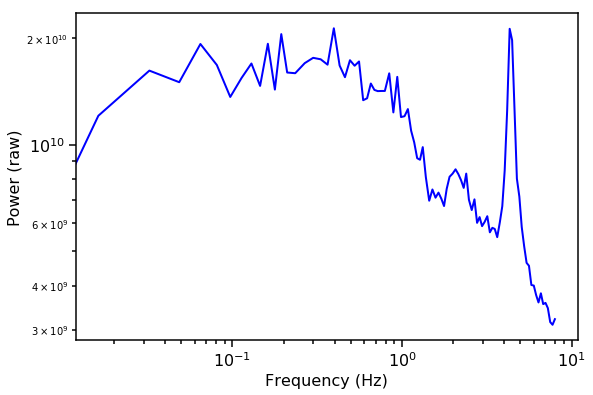

In [9]:
avg_ps_c = AveragedPowerspectrum()
avg_ps_c.norm = "leahy"
avg_ps_c.freq = lc_fits_c['FREQUENCY']
avg_ps_c.power = lc_fits_c['POWER']
avg_ps_c.power_err = lc_fits_c['ERROR']
avg_ps_c.df = avg_ps.freq[1] - avg_ps.freq[0]

range_start = 0
range_stop = int(len(avg_ps.freq))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.loglog(avg_ps_c.freq[range_start:range_stop], avg_ps_c.power[range_start:range_stop], lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

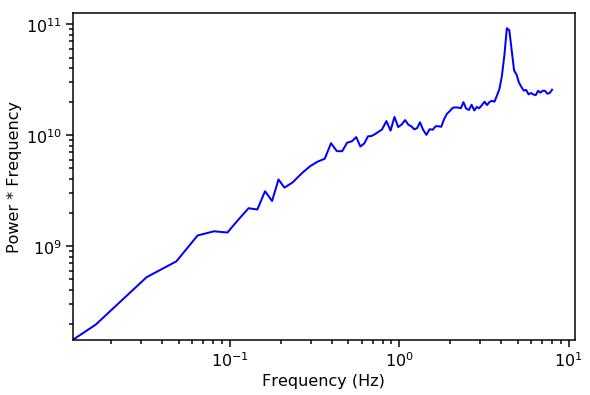

In [10]:
# Plotting power*freq vs. freq

power_freq_c = avg_ps_c.power * avg_ps_c.freq
range_start = 0
range_stop = int(len(avg_ps.freq))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.loglog(avg_ps_c.freq[range_start:range_stop], power_freq_c[range_start:range_stop], lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power * Frequency", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

## Fitting Model

78
Model: CompoundModel5
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=23.94443703, fwhm=1.)>

    [1]: <Lorentz1D(amplitude=1., x_0=0., fwhm=1.)>

    [2]: <Lorentz1D(amplitude=1., x_0=0., fwhm=1.)>

    [3]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>
Parameters:
    amplitude_0       x_0_0       fwhm_0 amplitude_1 ... amplitude_3 x_0_3 alpha_3
    ----------- ----------------- ------ ----------- ... ----------- ----- -------
            1.0 23.94443702697754    1.0         1.0 ...         1.0   1.0     1.0


/anaconda3/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: divide by zero encountered in power
  return amplitude * xx ** (-alpha)


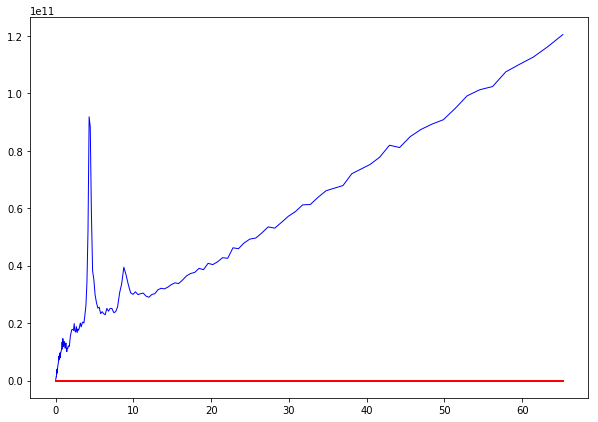

In [11]:
max_freq_index = find_nearest_arg(avg_ps_c.freq, 5)
x_0 = avg_ps.freq[max_freq_index]
print(max_freq_index)

model = models.Lorentz1D(x_0=x_0) + \
        models.Lorentz1D() + models.Lorentz1D() + \
        models.PowerLaw1D()
print(model)

fitter = fitting.LevMarLSQFitter()
fit_fn = fitter(model, avg_ps_c.freq, power_freq_c)
fit = fit_fn(avg_ps_c.freq)
# plotting
plt.figure(figsize=(10,7))
plt.plot(avg_ps_c.freq, power_freq_c, lw=1, color='blue')
plt.plot(avg_ps_c.freq, fit, lw=2, color="red")